In [1]:
pip install pycocotools matplotlib opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install albumentations==1.4.4



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


loading annotations into memory...
Done (t=1.42s)
creating index...
index created!


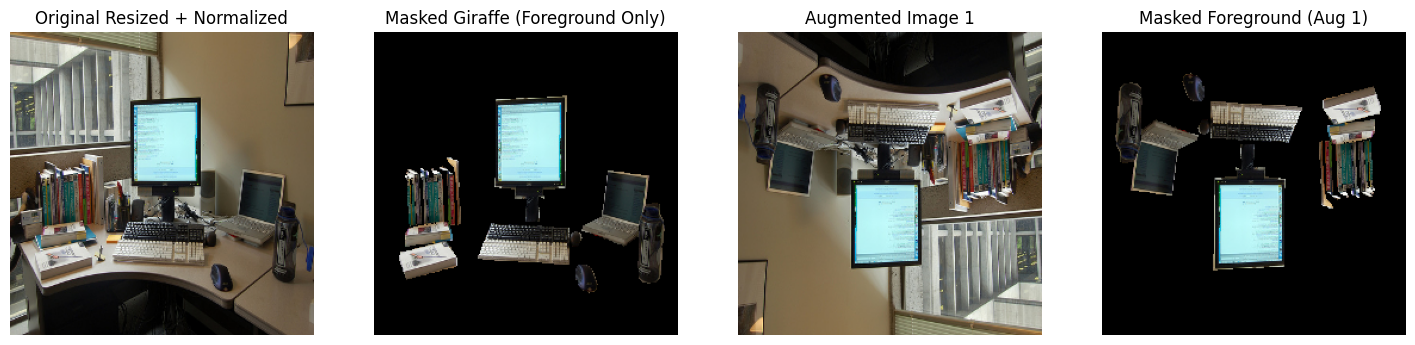

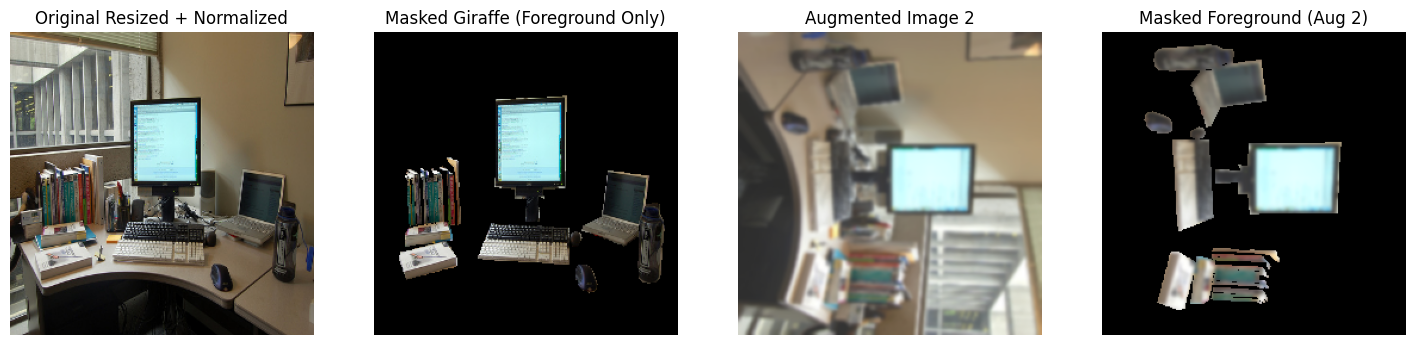

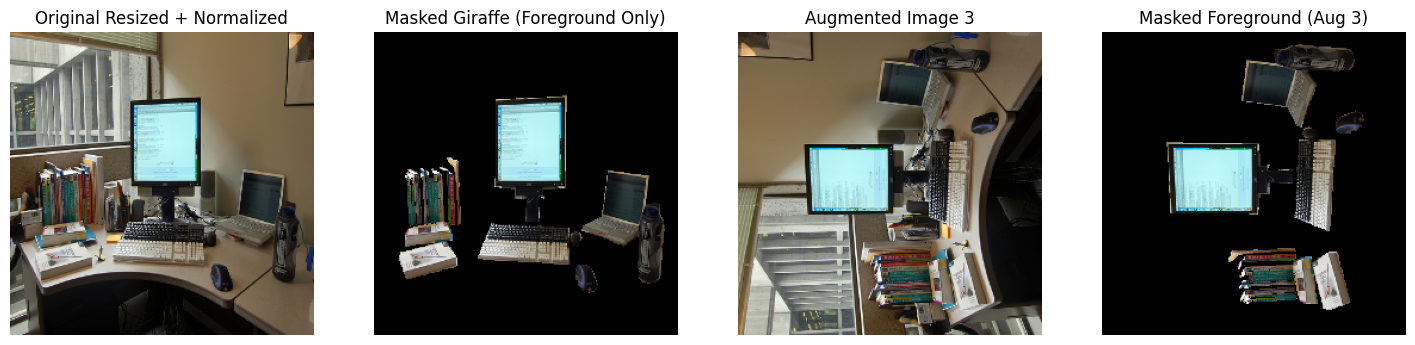

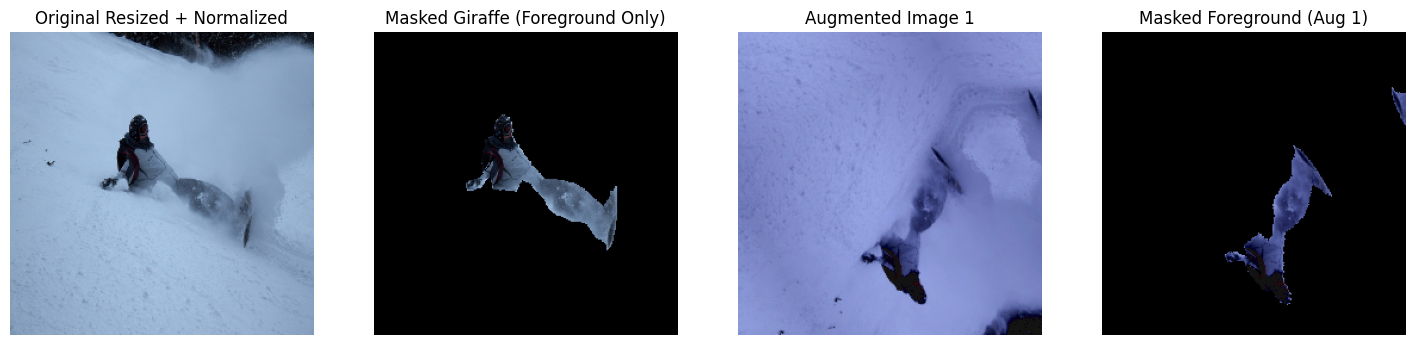

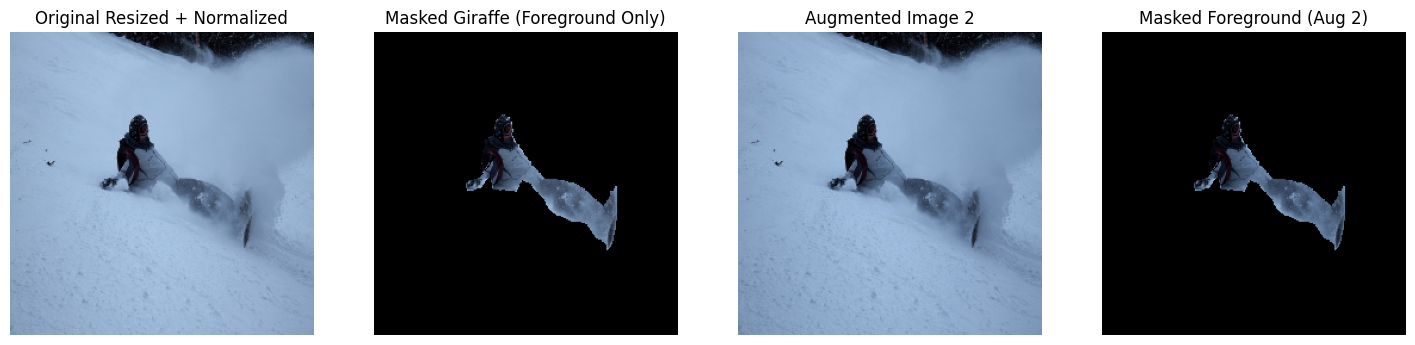

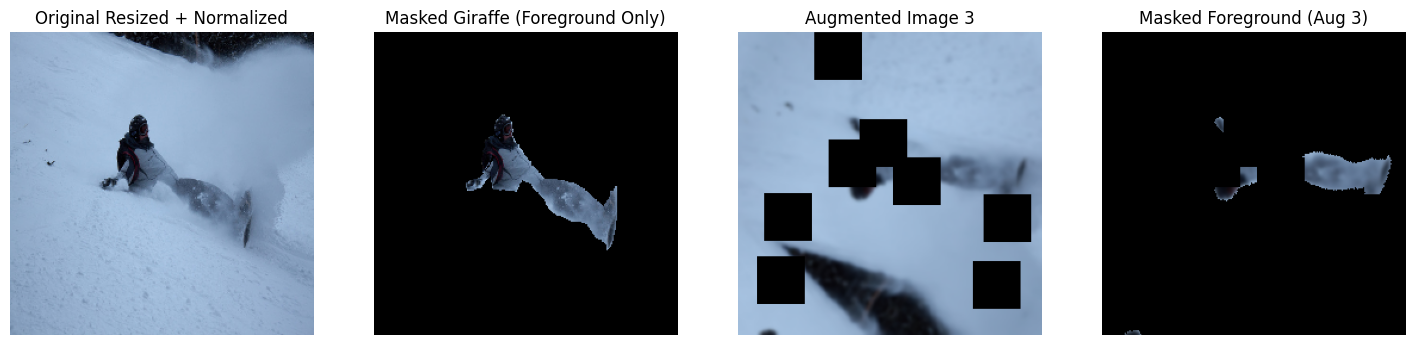

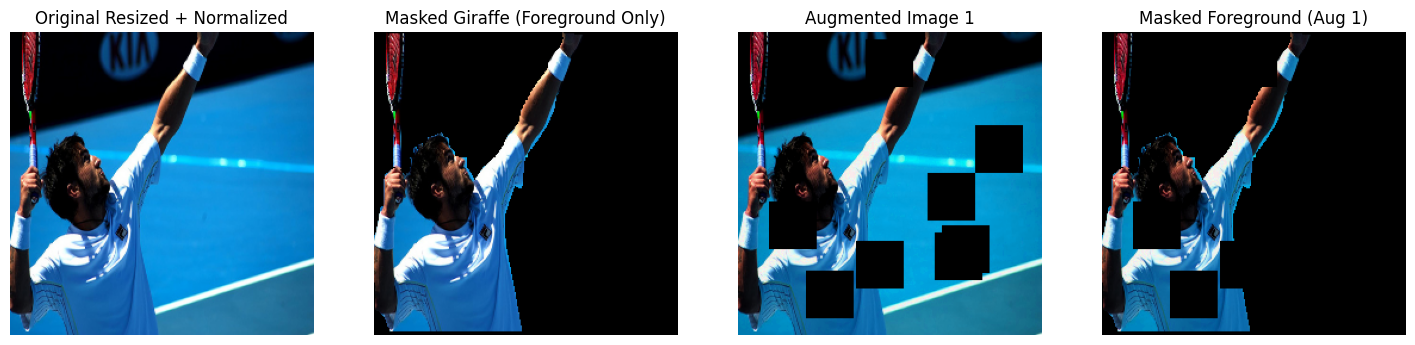

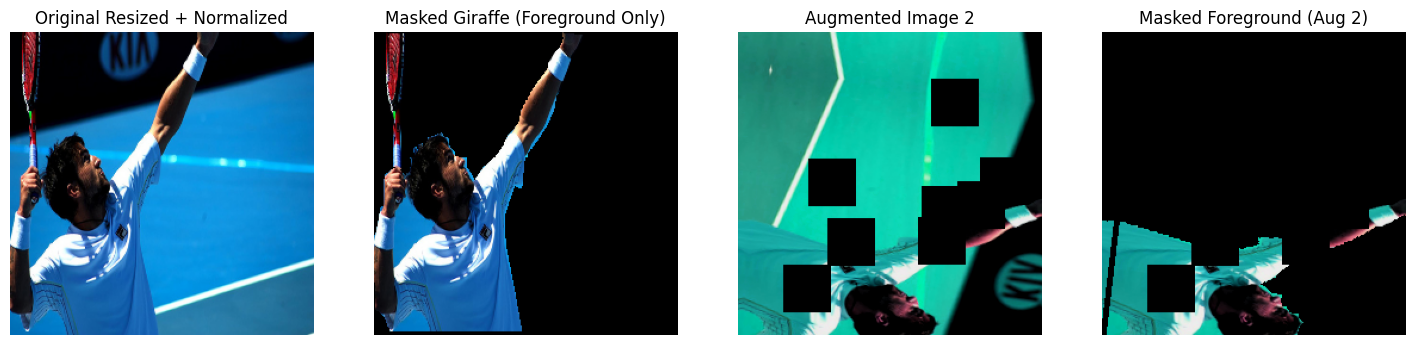

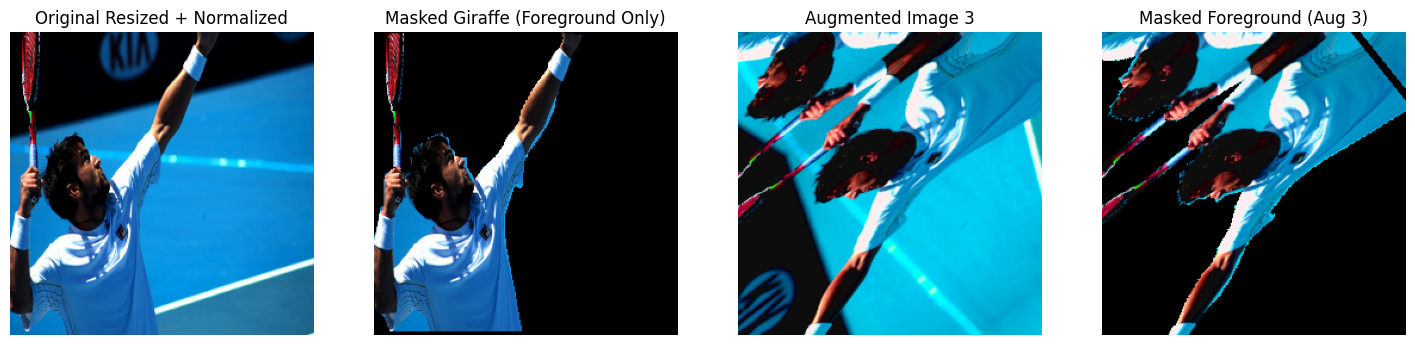

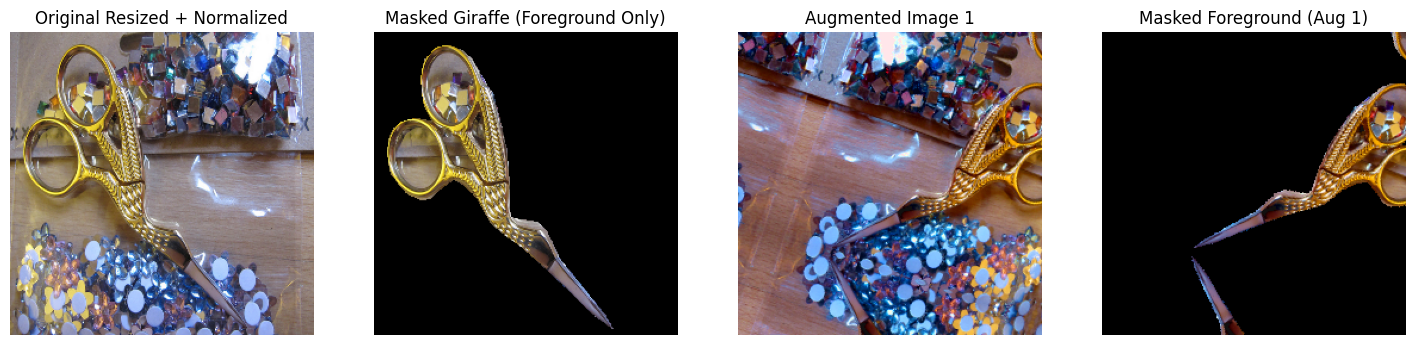

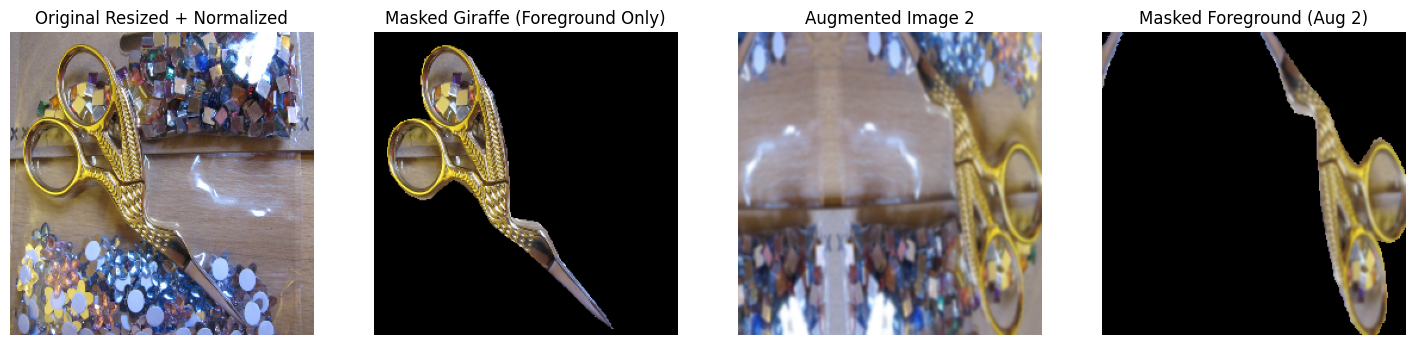

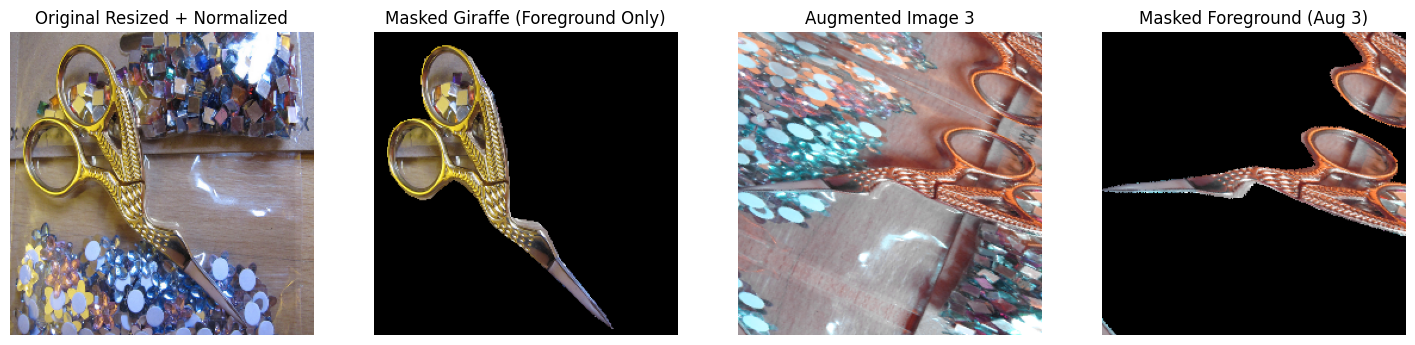

In [ ]:
import os, random, numpy as np, matplotlib.pyplot as plt, cv2
from pycocotools.coco import COCO
import albumentations as A

# Paths (update if needed)
imgDir  = r"C:\Users\KIIT0001\Desktop\infosys aiml\val2017\val2017"
annFile = r"C:\Users\KIIT0001\Desktop\infosys aiml\annotations_trainval2017\annotations\instances_val2017.json"

# Load COCO
coco = COCO(annFile)

# Get all image IDs
imgIds = coco.getImgIds()
random.shuffle(imgIds)

# Select 10 random images
sample_imgIds = imgIds[:10]

# Define STRONG augmentation pipeline
transform = A.Compose([
    A.Resize(255, 255),
    A.RandomRotate90(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.3, rotate_limit=60, p=0.7),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.4),
    A.RandomGamma(p=0.4),
    A.CoarseDropout(max_holes=8, max_height=40, max_width=40, p=0.3)  # random cutout
])

for idx, imgId in enumerate(sample_imgIds, 1):
    imgInfo = coco.loadImgs(imgId)[0]

    # Load image
    imgPath = os.path.join(imgDir, imgInfo['file_name'])
    image = cv2.cvtColor(cv2.imread(imgPath), cv2.COLOR_BGR2RGB)

    # Load annotations
    annIds = coco.getAnnIds(imgIds=imgInfo['id'])
    anns = coco.loadAnns(annIds)

    # Build combined mask
    mask = np.zeros((imgInfo['height'], imgInfo['width']), dtype=np.uint8)
    for ann in anns:
        mask |= coco.annToMask(ann).astype(np.uint8)

    # Resize + normalize original
    image_resized = cv2.resize(image, (255, 255)).astype(np.float32) / 255.0
    mask_resized = cv2.resize(mask, (255, 255), interpolation=cv2.INTER_NEAREST)

    # Masked original image
    masked_image = image_resized.copy()
    masked_image[mask_resized == 0] = 0

    # Apply several augmentations for the same image
    for aug_round in range(3):  # show 3 augmentations per image
        augmented = transform(image=image, mask=mask)
        aug_img, aug_mask = augmented["image"], augmented["mask"]
     # Normalize
        aug_img_norm = aug_img.astype(np.float32) / 255.0

        # Foreground only
        aug_masked_image = aug_img_norm.copy()
        aug_masked_image[aug_mask == 0] = 0

        # Display results
        fig, ax = plt.subplots(1, 4, figsize=(18, 6))
        ax[0].imshow(image_resized)
        ax[0].set_title("Original Resized + Normalized")
        ax[0].axis("off")

        ax[1].imshow(masked_image)
        ax[1].set_title("Masked Giraffe (Foreground Only)")
        ax[1].axis("off")

        ax[2].imshow(aug_img_norm)
        ax[2].set_title(f"Augmented Image {aug_round+1}")
        ax[2].axis("off")

        ax[3].imshow(aug_masked_image)
        ax[3].set_title(f"Masked Foreground (Aug {aug_round+1})")
        ax[3].axis("off")

        plt.show()
    
        